In [1]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ermark import ermarkHDGSolver
import numpy as np
from scipy.linalg import *
import matplotlib.pyplot as plt
import time as timeit

In [2]:
# def ermarkHDGSolver(mesh=None, order = 2, wx=1, wy=-0.0027, xs=0, ys=1, 
#                     eps=0.2, Q=1, v_depost=0.005,  vis=False)# 
#                     
# ......
# ......
#     return gfu
# Solve steady state eqn
# h0-mesh size, # order-poly order, # wx,wy-wind velocity, # xs,ys-source location
# eps-diffusion constant, # Q-source rate

In [3]:
# Define the geo and mesh
geo = SplineGeometry()
length = 50
height = 20
h0 = 1
geo.AddRectangle( (-3, 0), (length, height), bcs = ["bottom","right","top","left"])
mesh =  Mesh(geo.GenerateMesh(maxh=h0))

In [4]:
del_t = 0.01
nDA = 200
# Receptors
nRe = 10
reLocation = np.linspace(0, 10, nRe)
stdR_Ob = 0.1
# Source height
baseQ = 2
nSrc = 1
srcRate = 5
# Starting ground truth
# state = [theta, omega, amplitude]
x0T = np.array([0, 3, 1, baseQ])
nState = x0T.shape[0]
# Initial guess and uncertainty
x0 = np.array([0, 2, 0.5, baseQ-1])
P0 = np.array([[3,0,0,0],
              [0,4,0,0],
              [0,0,4,0],
              [0,0,0,5]])

In [5]:
# Wiener velocity model for state forward
q1 = 0.2  # theta and omega noise
q2 = 1  # amplitude noise
A = np.array([[1, del_t, 0, 0],
              [0,    1,  0, 0],
              [0,    0,  1, 0],
              [0,    0,  0, 1]])
Q = np.array([[1/3*del_t**3*q1, 1/2*del_t**2*q1,        0,   0],
              [1/2*del_t**2*q1,        del_t*q1,        0,   0],
              [              0,               0, del_t*q2,   0],
              [              0,               0,        0,1e-6]])
mean = np.zeros(nState)
# UKF parameters
alpha = 1.5
kappa = 5-nState
beta = 2
lam = alpha**2*(nState+kappa)-nState
# weight
w_m = np.hstack((lam/(nState+lam),
                 np.ones(2*nState)*1/2/(nState+lam)))
w_c = np.hstack((lam/(nState+lam)+(1-alpha**2+beta),
                 np.ones(2*nState)*1/2/(nState+lam)))
# sigma points storage
sigma_pnt = np.zeros((2*nState+1, nState))
trans_sigma = np.zeros((2*nState+1, nRe))

In [6]:
###############
# Start UKF
###############
t0 = timeit.time()
# Data storage
xLst_T = np.zeros([nDA, nState])
xLst_T[0,:] = x0T
QLst_T = np.zeros([nDA, nSrc])
QLst_T[0,:] = x0T[3] + x0T[2]*sin(x0T[0])

receptorLst_Ob = np.zeros([nDA, nRe])

xLst_Filter = np.zeros([nDA, nState])
xLst_Filter[0, :] = x0
PLst_Filter = np.zeros([nDA, nState, nState])
PLst_Filter[0, :, :] = P0
QLst_Filter = np.zeros([nDA, nSrc])
QLst_Filter[0, :] = x0[3] + x0[2]*sin(x0[0])

i = 1
xTmp = x0T
np.random.seed(111)
while i < nDA:
    # Ground Truth
    # Synthetic data generation
    xTmp = A @ xTmp + np.random.multivariate_normal(mean, Q)
    xLst_T[i, :] = xTmp
    QLst_T[i, :] = xTmp[3] + xTmp[2] * sin(xTmp[0])
    gfu = ermarkHDGSolver(mesh=mesh, order=2, ys=QLst_T[i,:], Q=srcRate)
    recepData = np.array([gfu.components[0](mesh(p, 5e-2)) for p in reLocation])
    # What we observe
    receptorLst_Ob[i, :] = recepData + np.random.multivariate_normal(np.zeros(nRe), np.eye(nRe)*stdR_Ob**2)

    # UKF process
    # prediction of next state
    m_ = A @ x0
    P_ = A @ P0 @ A.T + Q
    # predict observation, transform sigma points
    sqrt_P_ = sqrtm(P_)
    # sigma points
    sigma_pnt[0, :] = m_
    for j in range(1, nState + 1):
        sigma_pnt[j, :] = m_ + sqrt_P_[:, j - 1] * sqrt(nState + lam)
        sigma_pnt[nState + j, :] = m_ - sqrt_P_[:, j - 1] * sqrt(nState + lam)
    # transform
    # expected observation, black box (here is ermark HDG solver)
    recepData_expect = np.zeros(nRe)
    for j in range(0, 2 * nState + 1):
        Q_tmp = sigma_pnt[j,3] + sigma_pnt[j, 2] * sin(sigma_pnt[j, 0])
        if Q_tmp<0:
            Q_tmp = 0
        gfu_tmp = ermarkHDGSolver(mesh=mesh, order=2, ys=Q_tmp, Q=srcRate)
        recepData_tmp = np.array([gfu_tmp.components[0](mesh(p, 5e-2)) for p in reLocation])
        trans_sigma[j,:] = recepData_tmp
        recepData_expect = recepData_expect + w_m[j] * recepData_tmp

    S = 0
    C = 0
    for j in range(0, 2 * nState + 1):
        if nRe == 1:
            S = S + w_c[j] * (trans_sigma[j, :] - recepData_expect) ** 2
            C = C + w_c[j] * (sigma_pnt[j, :] - recepData_expect) * (trans_sigma[j, :] - recepData_expect)
        else:
            S = S + w_c[j] * (trans_sigma[j, :] - 
                              recepData_expect).reshape(nRe, 1) * (trans_sigma[j, :] - recepData_expect)
            C = C + w_c[j] * (sigma_pnt[j, :] - m_).reshape(nState, 1) * (trans_sigma[j, :] - recepData_expect)
    S = S + np.eye(nRe)*stdR_Ob**2
    if nRe == 1:
        invS = 1 / S
        K = C * invS
    else:
        invS = inv(S)
        K = C @ invS
    # update
    if nRe == 1:
        x0 = m_ + K * (receptorLst_Ob[i, :] - recepData_expect)
        P0 = P_ - K.reshape(nState, 1) * S * K
    else:
        x0 = m_ + K @ (receptorLst_Ob[i, :] - recepData_expect)
        P0 = P_ - K @ S @ K.T
    xLst_Filter[i, :] = x0
    PLst_Filter[i, :, :] = P0
    QLst_Filter[i, :] = x0[3] + x0[2] * sin(x0[0])
    
    print("DA step: %d. Elipsed time: %.2e. True H: %.2e. Filtered H: %.2e."
          %(i, timeit.time()-t0,QLst_T[i, :],QLst_Filter[i, :]),end="\r",flush=True)
    i += 1

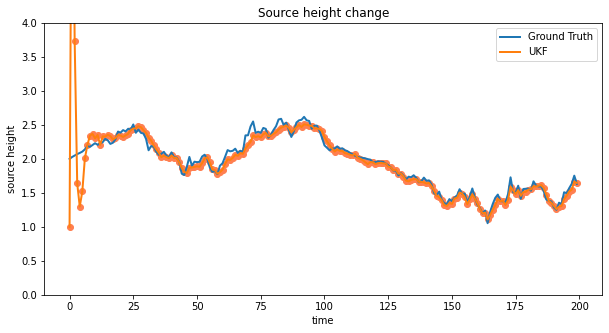

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Source height change")
ax.plot(range(0, nDA),QLst_T, linewidth=2, label='Ground Truth')
ax.plot(range(0, nDA),QLst_Filter, linewidth=2, label='UKF')
ax.scatter(range(0, nDA),QLst_Filter,color='coral')
ax.set_xlabel("time")
ax.set_ylabel("source height")
ax.set_ylim([0,4])
ax.legend()

In [8]:
###############
# Start RTS
###############
i = nDA-2
while i >= 0:
    # current step m and P after filtering
    x_tmp = xLst_Filter[i, :]
    P_tmp = PLst_Filter[i, :, :]
    
    # RTS
    # predict the observation
    x_ = A@x_tmp
    P_ = A@P_tmp@A.T + Q
    # smoothing
    G = P_tmp@A@inv(P_)
    xLst_Filter[i, :] = x_tmp + G@(xLst_Filter[i+1, :] - x_)
    PLst_Filter[i, :, :] = P_tmp + G@(PLst_Filter[i+1, :, :] - P_)@G.T
    QLst_Filter[i, :] = xLst_Filter[i, 3] + xLst_Filter[i, 2]*sin(xLst_Filter[i, 0])
    i -= 1

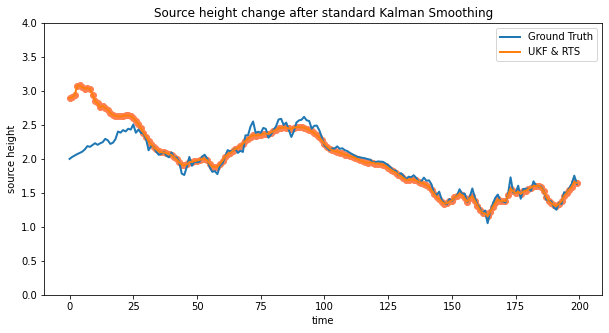

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Source height change after standard Kalman Smoothing")
ax.plot(range(0, nDA),QLst_T, linewidth=2, label='Ground Truth')
ax.plot(range(0, nDA),QLst_Filter, linewidth=2, label='UKF & RTS')
ax.scatter(range(0, nDA),QLst_Filter,color='coral')
ax.set_xlabel("time")
ax.set_ylabel("source height")
ax.set_ylim([0,4])
ax.legend()

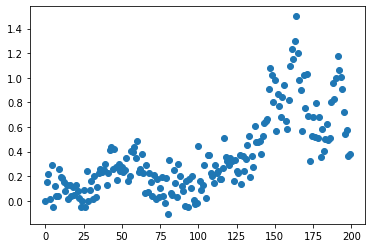

In [10]:
plt.scatter(range(0,nDA),receptorLst_Ob[:, 1])